In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('/project/dissertation/')

# Load custom modules
from utils.config import config as cf
import utils.feature_eng_utils as feature_utils

import warnings
warnings.filterwarnings(action='ignore')


In [2]:
# Load training data
df = pd.read_csv(cf.DATA_PATH+'/train.csv', parse_dates=['Date'])
df['Description'] = df['Description'].fillna('')

df = feature_utils.preprocess_description(df, True)
df['isWeekday'] = (df['Date'].dt.weekday < 5).astype('int')

======= Load Currency :::  /project/dissertation/resources/currency.csv
Total  285  rows
======= Load Cities name :::  /project/dissertation/resources/nz_cities.csv
Total  1040  rows
======= Load Stopword name :::  /project/dissertation/resources/stop_words.csv
Total  10  rows


In [3]:
# Load text embeddings and merge with numeric features
fasttext_embeddings = np.load(cf.EXPORT_PATH+'/text_embeddings/FastText.npy')
desc_embedding = pd.DataFrame(fasttext_embeddings)

scaler = StandardScaler()
df['Amount_t'] = scaler.fit_transform(df['Amount_logabs'].values.reshape(-1,1))
X = pd.concat([desc_embedding,  df[['isExpense', 'isAcctNo', 'isOverseas']]], axis=1)

y = df['label']
X.head()

,0,1,2,3,4,5,6,7,8,9,...,293,294,295,296,297,298,299,isExpense,isAcctNo,isOverseas
0,0.017959,-0.013190,0.014538,-0.018996,0.048453,-0.000470,-0.007357,-0.064340,-0.003274,0.028703,...,0.002667,0.010593,-0.047581,-0.063368,-0.001983,-0.020694,-0.034144,1,0,0
1,-0.032586,0.013775,0.019253,-0.055363,-0.094376,-0.039773,-0.007985,-0.124254,0.025856,0.009919,...,0.025153,-0.022944,-0.026166,0.012058,-0.005366,-0.027929,-0.046564,1,0,0
2,-0.019716,-0.068639,-0.001862,0.024958,-0.046710,-0.060750,0.012915,-0.089007,0.026206,-0.002590,...,-0.025809,-0.009938,0.006084,0.022432,0.027588,-0.009896,-0.008567,1,0,0
3,0.002800,-0.005657,0.041282,-0.067148,-0.060220,-0.032235,-0.036372,-0.105444,-0.013942,0.059444,...,0.002112,-0.007724,0.009107,0.001799,-0.002830,-0.053920,-0.026631,1,0,0
4,-0.001916,-0.024082,0.014094,-0.001462,-0.026449,-0.019436,-0.022096,-0.102912,0.004760,-0.047719,...,-0.017592,0.043732,-0.000662,0.009683,0.026104,0.030170,-0.007618,0,0,0


### Define Models

In [4]:
#base model
base_models = {
    'RandomForest' : RandomForestClassifier(n_estimators=50, max_depth=40, max_features='auto' , class_weight='balanced', random_state=cf.RANDOM_ST),
    'ExtraTree' : ExtraTreesClassifier(n_estimators=200, max_depth= 20, max_features='auto', class_weight='balanced', random_state=cf.RANDOM_ST),
    'SVC': SVC(C=100, kernel= 'rbf', gamma='scale',class_weight='balanced', random_state=cf.RANDOM_ST),
    'XGBoost' : XGBClassifier(random_state=cf.RANDOM_ST),
    'LogisticRegression' : LogisticRegression(C=100, solver='newton-cg', multi_class='auto', class_weight='balanced', random_state = cf.RANDOM_ST)
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=99)

# 1. Feature Engineering for Numeric Features

## Analyse Transaction Amount

Text(0.5, 1.0, 'Standardised log(abs(Amount)+0.01)')

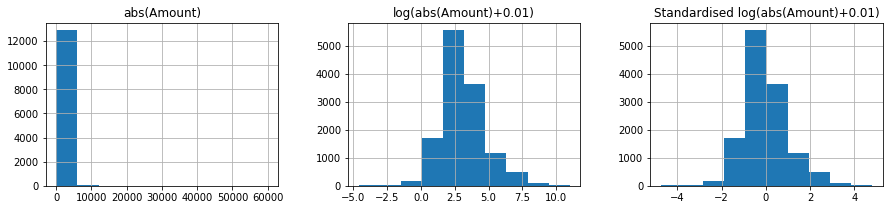

In [5]:
abs_amt = pd.DataFrame(df['Amount'].abs(), columns=['Amount'])
log_abs_amt = np.log(abs_amt+0.01)
scaler = StandardScaler()
scale_log_abs_amt = pd.DataFrame(scaler.fit_transform(log_abs_amt))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,3))
abs_amt.hist(ax=axes[0])
log_abs_amt.hist(ax=axes[1])
scale_log_abs_amt.hist(ax=axes[2])
axes[0].set_title('abs(Amount)')
axes[1].set_title('log(abs(Amount)+0.01)')
axes[2].set_title('Standardised log(abs(Amount)+0.01)')


[Text(0.5, 1.0, 'Distribution of Transaction Amount by Category')]

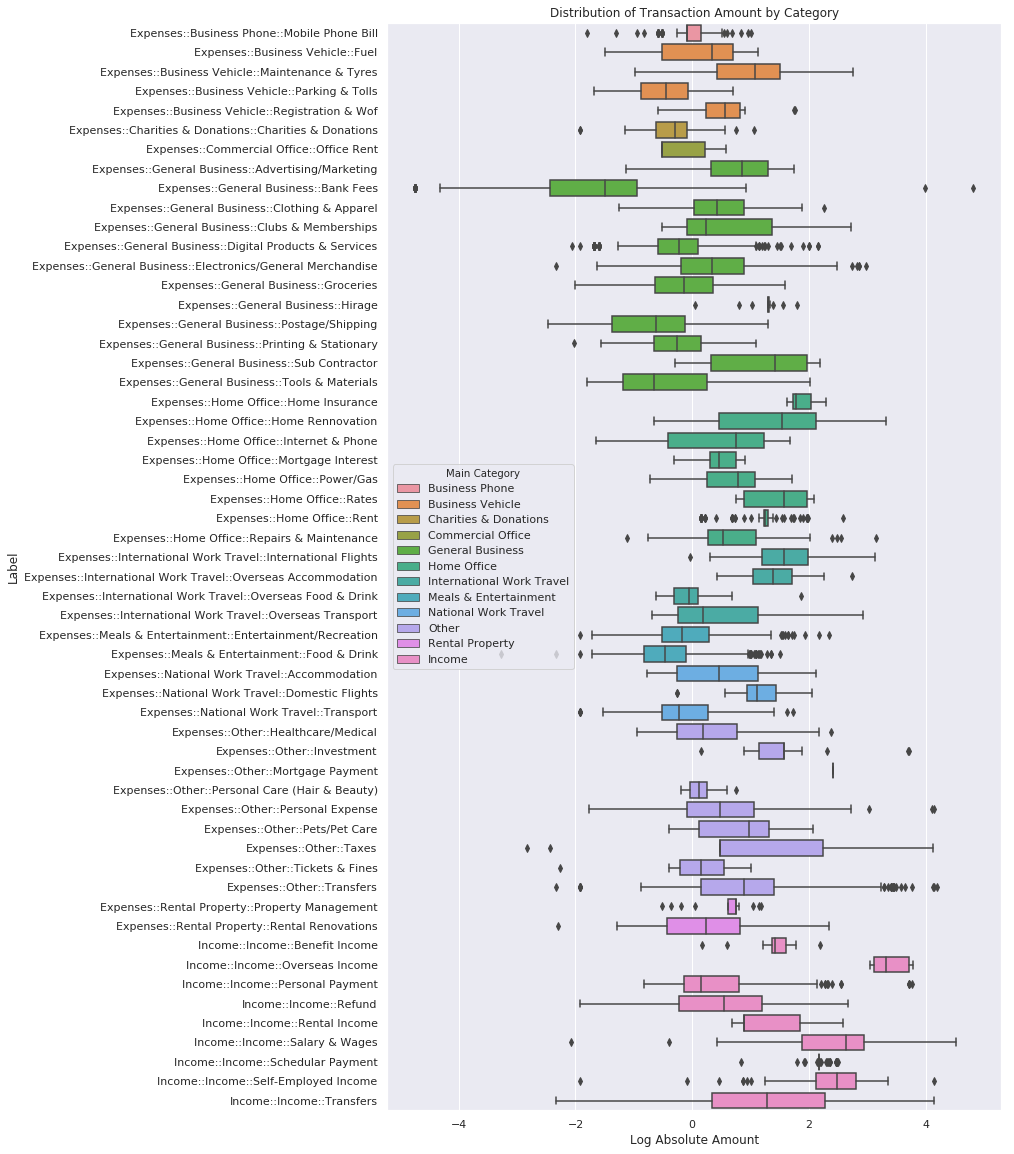

In [6]:
t = df.copy()
t['label'] = t['label'].str.title()
t['Main Category'] = t['Main Category'].str.title()
t['Amount'] = t['Amount_t']
t = t.sort_values('label')
plt.figure(figsize=(11,20))
sns.set_context('notebook', font_scale=1)
sns.set_style('darkgrid')
fig = sns.boxplot(x='Amount', y='label', hue='Main Category', data=t, dodge=False)
fig.set_xlabel('Log Absolute Amount')
fig.set_ylabel('Label')
fig.set(title='Distribution of Transaction Amount by Category')

## Numeric Features Selection

In [12]:
X = desc_embedding
baseline_scores = cross_val_score(base_models['SVC'], X, y, cv=kfold, scoring='f1_macro', n_jobs=-1)
baseline_scores.mean()

0.8051660190493314

In [13]:
features_dict = {
    'isExpense': ['isExpense'],
    'Amount' : ['Amount_t'],
    'isAcctNo' : ['isAcctNo'],
    'isForeignCurr' : ['isForeignCurr'],
    'isWeekday' : ['isWeekday'],
    'isOverseas' : ['isOverseas'],
    'isExpense+isAcctNo': ['isExpense', 'isAcctNo'],
    'isExpense+isOverseas': ['isExpense', 'isOverseas'],
    'isExpense+isAcctNo+isOverseas': ['isExpense', 'isAcctNo', 'isOverseas'],
    'isExpense+isAcctNo+isForeignCurr': ['isExpense', 'isAcctNo', 'isForeignCurr'],
    'isExpense+isAcctNo+isOverseas+isForeignCurr': ['isExpense', 'isAcctNo', 'isOverseas', 'isForeignCurr'],
}
feature_results = dict()
for key, value in features_dict.items():
    X = pd.concat([desc_embedding,  df[value]], axis=1)
    score = cross_val_score(base_models['SVC'], X, y, cv=kfold, scoring='f1_macro', n_jobs=-1)
    feature_results[key] = score.mean()
    print('{} : {}'.format(key, score.mean()))

isExpense : 0.8157420702205618
Amount : 0.7786433486955537
isAcctNo : 0.8091764511039381
isForeignCurr : 0.804124016071784
isWeekday : 0.7886703128194144
isOverseas : 0.8048369403217382
isExpense+isAcctNo : 0.8201545107084603
isExpense+isAcctNo+isOverseas : 0.8217113548345247
isExpense+isAcctNo+isForeignCurr : 0.8193497432701161
isExpense+isAcctNo+isOverseas+isForeignCurr : 0.8208523518098708


In [14]:
baseline = baseline_scores.mean()
feature_results['baseline'] = baseline
feature_results_df = pd.DataFrame(pd.Series(feature_results), columns=[ 'Score']).reset_index()
feature_results_df = feature_results_df.sort_values('Score', ascending=False)
feature_results_df.to_csv(cf.EXPORT_PATH + '/feature_selection_results.csv', index=False)

,index,Score
7,isExpense+isAcctNo+isOverseas,0.821711
9,isExpense+isAcctNo+isOverseas+isForeignCurr,0.820852
6,isExpense+isAcctNo,0.820155
8,isExpense+isAcctNo+isForeignCurr,0.819350
0,isExpense,0.815742
2,isAcctNo,0.809176
10,baseline,0.805166
5,isOverseas,0.804837
3,isForeignCurr,0.804124
4,isWeekday,0.788670


In [7]:
feature_results_df = pd.read_csv(cf.EXPORT_PATH + '/feature_selection_results.csv', index_col=0)
feature_results_df['Score']= feature_results_df['Score'].round(3)
feature_results_df

,Score
index,
isExpense+isAcctNo+isOverseas,0.822
isExpense+isAcctNo+isOverseas+isForeignCurr,0.821
isExpense+isAcctNo,0.820
isExpense+isAcctNo+isForeignCurr,0.819
isExpense,0.816
isAcctNo,0.809
baseline,0.805
isOverseas,0.805
isForeignCurr,0.804


----------------------------------------------------

# 2. Classification Model Selection

In [26]:
all_models_unsorted_scores = list()
for model_name, model in base_models.items():
    scoring = {'accuracy': 'accuracy',  'precision': 'precision_macro', 'recall': 'recall_macro', 'f1': 'f1_macro'}
    score = cross_validate(model, X, y, cv=kfold, scoring=scoring, return_train_score=False, n_jobs=-1)
    all_models_unsorted_scores.append({'Model': model_name, 'Accuracy': score['test_accuracy'].mean(), 'Precision':score['test_precision'].mean(), 
                               'Recall': score['test_recall'].mean(), 'F1-score': score['test_f1'].mean(), 'fit_time': score['fit_time'].mean(), 'score_time': score['score_time'].mean()})
    print(model_name , ' : ' , score['test_f1'].mean())

RandomForest  :  0.8005796563946811
ExtraTree  :  0.8033814154258103
SVC  :  0.8217113548345247
XGBoost  :  0.8120491291472994
LogisticRegression  :  0.7933935180745162


In [34]:
all_models = pd.DataFrame(all_models_unsorted_scores)
all_models.to_csv(cf.EXPORT_PATH + 'model_results/all_models.csv', index=False)

## Load model results from file & plot graphs

Note: To include Neural Network model result, 
please run file <code>3_Neural_Network.ipynb</code> before this part.

In [8]:
import glob
path = cf.EXPORT_PATH + 'model_results/*.csv'
data = list()
for filename in glob.glob(path):
    print(filename)
    data.append(pd.read_csv(filename))
all_models = pd.concat(data, ignore_index=True, sort=False)
all_models

/project/dissertation/output/model_results/all_models.csv
/project/dissertation/output/model_results/nn.csv


,Accuracy,F1-score,Model,Precision,Recall,fit_time,score_time
0,0.904938,0.800580,RandomForest,0.863842,0.782214,14.694539,0.334934
1,0.903476,0.803381,ExtraTree,0.868787,0.783667,6.678964,1.123576
2,0.913369,0.821711,SVC,0.842780,0.829608,21.959302,16.998183
3,0.912763,0.812049,XGBoost,0.907058,0.770858,513.019139,6.576587
4,0.869198,0.793394,LogisticRegression,0.784369,0.836503,50.290874,0.067785
5,0.922062,0.833105,NeuralNetwork,0.890407,0.811584,67.518804,NaN


## Compare Classification models

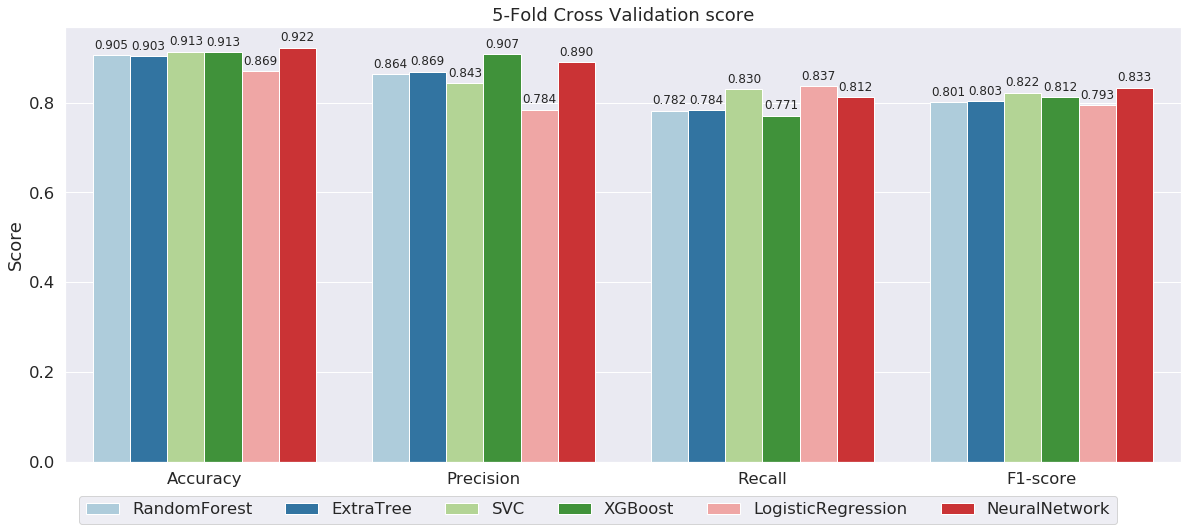

In [9]:
all_scores = all_models.melt(id_vars='Model', value_vars=['Accuracy', 'Precision','Recall','F1-score'], var_name='Score_type', value_name='Score')
plt.figure(figsize=(20, 8))
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.5)
fig = sns.barplot(y='Score', x='Score_type', data=all_scores, hue='Model', palette='Paired')
fig.set(title="5-Fold Cross Validation score")
#Annotate bar
for p in fig.patches:
    fig.annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=12)
fig.set(xlabel="")
fig.legend(loc='center right', bbox_to_anchor=(0.95, -0.11), ncol=6)

In [10]:
fittime_df = all_models[['Model','fit_time']]
fittime_df = fittime_df.sort_values(['fit_time'], ascending=False)
fittime_df

,Model,fit_time
3,XGBoost,513.019139
5,NeuralNetwork,67.518804
4,LogisticRegression,50.290874
2,SVC,21.959302
0,RandomForest,14.694539
1,ExtraTree,6.678964


In [11]:
# Set colour for each model to be the same as previous chart
order = list(fittime_df.sort_values(['fit_time'], ascending=False).index)
palette = sns.color_palette('Paired', n_colors=len(all_models))
my_palette = dict()
for i in range(len(all_models)):
    my_palette[all_models.iloc[i]['Model']] = palette[i]
my_palette

{'RandomForest': (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 'ExtraTree': (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 'SVC': (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 'XGBoost': (0.2, 0.6274509803921569, 0.17254901960784313),
 'LogisticRegression': (0.984313725490196, 0.6039215686274509, 0.6),
 'NeuralNetwork': (0.8901960784313725,
  0.10196078431372549,
  0.10980392156862745)}

## Model Fitting time

[Text(0, 0.5, 'Fitting Time (seconds)')]

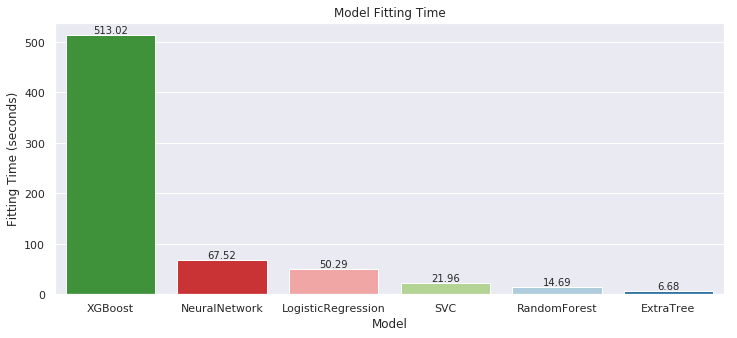

In [12]:
plt.figure(figsize=(12, 5))
sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1)
fig = sns.barplot(x='Model', y='fit_time' , data=fittime_df,  palette=my_palette)
fig.set(title="Model Fitting Time")
#Annotate bar
for p in fig.patches:
    fig.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points', fontsize=10)
fig.set(ylabel='Fitting Time (seconds)')
